In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections
import datetime

In [9]:
def rank_transformation(df_a, df_b, metric):
    df = pd.concat([df_a, df_b], axis = 0)
    df['rank'] = df[metric].rank()
    
    return df

In [207]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode # кодирует байтоподобный объект с помощью Base64 и возвращает закодированную байтовую строку.
    salt = os.urandom(8)
    
    return b64encode(salt).decode('ascii')

In [208]:
def groups_splitter(df, user_salt=None):
    
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt
    
    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[['user_id', 'group']].drop_duplicates()

## Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на метрике cart_added_cnt

In [25]:
shop_metrics_new = pd.read_csv('shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_csv('shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')

In [5]:
shop_metrics_new.head(3)

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0


<Axes: xlabel='cart_added_cnt', ylabel='Count'>

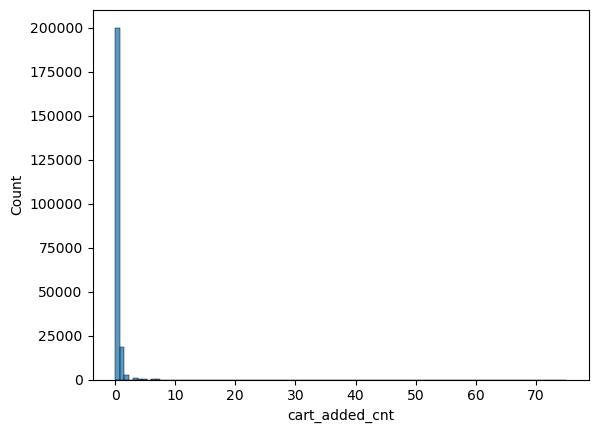

In [8]:
sns.histplot(data=shop_metrics_new, x='cart_added_cnt', bins=100)

In [10]:
ranked = rank_transformation(shop_metrics_new[shop_metrics_new.group == 'A'], 
                             shop_metrics_new[shop_metrics_new.group == 'B'], 'cart_added_cnt')
ranked

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,rank
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,100038.5
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,100038.5
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,100038.5
5,1515915625353400724,A,1,2,103.33,0.0,0.0,0,0,100038.5
7,1515915625353416040,A,1,13,1861.21,0.0,0.0,0,0,100038.5
...,...,...,...,...,...,...,...,...,...,...
222516,1515915625611023671,B,1,1,32.22,0.0,0.0,0,0,100038.5
222517,1515915625611023730,B,1,1,219.94,0.0,0.0,0,0,100038.5
222518,1515915625611024014,B,1,1,80.03,0.0,0.0,0,0,100038.5
222519,1515915625611024020,B,1,1,64.92,0.0,0.0,0,0,100038.5


<Axes: xlabel='rank', ylabel='Count'>

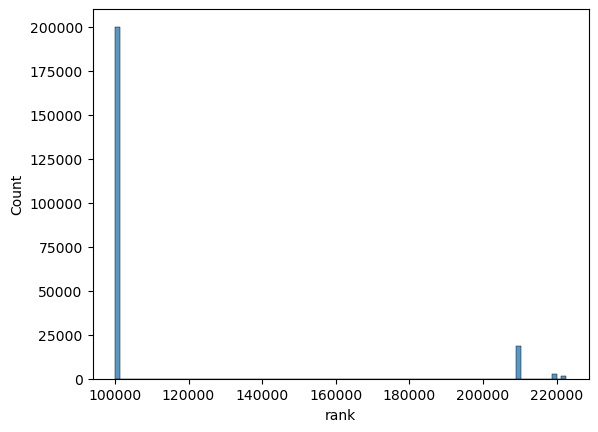

In [15]:
sns.histplot(data=ranked, x='rank', bins=100)

In [12]:
print(ranked[ranked.group == 'A']['rank'].mean(),
      ranked[ranked.group == 'B']['rank'].mean(), 
      ((ranked[ranked.group == 'B']['rank'].mean() - ranked[ranked.group == 'A']['rank'].mean()) / 
       ranked[ranked.group == 'A']['rank'].mean()*100))

111170.45633348604 111351.6421897482 0.16298022175842064


Берем пороговое значение в 5%

H0 - среднее каждой выборки равны

In [13]:
stats.ttest_ind(ranked[ranked.group == 'A']['rank'], ranked[ranked.group == 'B']['rank'])

Ttest_indResult(statistic=-1.2743727811526857, pvalue=0.20253266477504916)

In [14]:
stats.mannwhitneyu(ranked[ranked.group == 'A']['rank'], ranked[ranked.group == 'B']['rank'])

MannwhitneyuResult(statistic=6179368188.5, pvalue=0.2025319893087626)

#### Вывод: Различий между выборками скорее всего нет, оба критерия показывают примерно одинаковые значения

## Реализовать cuped-трансформацию и сравнить мощность t-критерия на:


### Обычной метрике cart_added_cnt

In [61]:
def cuped_transform(df, metrics):

    new_columns = [str(m+'_cuped') for m in metrics]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)

    df_mini = df.fillna(0)
    for m in metrics:
        covariate_column = str(m+'_covariate')
        cuped_column = str(m+'_cuped')
        mean_covariate = df_mini[covariate_column].mean()

        theta = (df_mini[m].cov(df_mini[covariate_column]))/(df_mini.loc[:,covariate_column].var())
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta

    df.update(df_mini)

    return df.drop_duplicates()

In [62]:
shop_metrics_all = pd.merge(shop_metrics_new,
                            shop_metrics_old[['user_id', 'cart_added_cnt']],
                            on=['user_id'],
                            how='left')

In [63]:
shop_metrics_all = shop_metrics_all\
                   .rename(columns={'cart_added_cnt_x': 'cart_added_cnt',
                                    'cart_added_cnt_y': 'cart_added_cnt_covariate'})

Данные из датасета old примем, как ковариату, из new оставим без изменений

In [64]:
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt'])

In [65]:
shop_metrics_all_cuped

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,cart_added_cnt_cuped
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0,0.132761
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0,0.132761
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0,0.132761
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0,0.132761
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0,0.132761
...,...,...,...,...,...,...,...,...,...,...,...
222516,1515915625611023671,B,1,1,32.22,0.0,0.0,0,0,0,0.132761
222517,1515915625611023730,B,1,1,219.94,0.0,0.0,0,0,0,0.132761
222518,1515915625611024014,B,1,1,80.03,0.0,0.0,0,0,0,0.132761
222519,1515915625611024020,B,1,1,64.92,0.0,0.0,0,0,0,0.132761


In [67]:
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].mean()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].mean()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].mean()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].mean()}')


метрика_cuped A: 0.13638231572656984,         метрика_cuped B: 0.1372102898471449
метрика без cuped A: 0.1350419058398685,         метрика без cuped B: 0.1385521582733813


In [66]:
stats.ttest_ind(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_cuped'], 
                shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_cuped'])

Ttest_indResult(statistic=-1.3855896128552472, pvalue=0.16587364048446882)

#### T-test не нашел различий между выборками после cuped-трансформации

### Метрика cart_added_cnt (а после подвергнуть ранговому преобразованию)

In [69]:
ranked = rank_transformation(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A'], 
                             shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B'], 'cart_added_cnt_cuped')
ranked.head(3)

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,cart_added_cnt_cuped,rank
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0,0.132761,100501.5
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0,0.132761,100501.5
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0,0.132761,100501.5


In [70]:
stats.ttest_ind(ranked[ranked.group == 'A']['rank'], ranked[ranked.group == 'B']['rank'])

Ttest_indResult(statistic=-1.4459909525623789, pvalue=0.14818114788143422)

In [82]:
diff_mean = (ranked[ranked.group == 'B']['rank'].mean() - ranked[ranked.group == 'A']['rank'].mean()) / ranked[ranked.group == 'A']['rank'].mean()*100

In [83]:
print(f'метрика_cuped A: {ranked[ranked.group == "A"]["rank"].mean()}, \
        метрика_cuped B: {ranked[ranked.group == "B"]["rank"].mean()}')
print(f'разница средних: {diff_mean}')

метрика_cuped A: 111157.3299691882,         метрика_cuped B: 111364.78283723022
разница средних: 0.186629948829756


#### T-test не нашел различий между выборками после cuped-трансформации и последующему ранговому преобразованию

### Логарфимированной метрике cart_added_cnt

In [55]:
shop_metrics_all

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
222516,1515915625611023671,B,1,1,32.22,0.0,0.0,0,0,0
222517,1515915625611023730,B,1,1,219.94,0.0,0.0,0,0,0
222518,1515915625611024014,B,1,1,80.03,0.0,0.0,0,0,0
222519,1515915625611024020,B,1,1,64.92,0.0,0.0,0,0,0


In [56]:
shop_metrics_all['cart_added_cnt_ln'] = np.log(shop_metrics_all['cart_added_cnt'] + 1)
shop_metrics_all['cart_added_cnt_ln_covariate'] = np.log(shop_metrics_all['cart_added_cnt_covariate'] + 1)

In [57]:
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt_ln'])

In [60]:
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_ln_cuped"].mean()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_ln_cuped"].mean()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].mean()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].mean()}')


метрика_cuped A: 0.08034157852348506,         метрика_cuped B: 0.08072086382541407
метрика без cuped A: 0.1350419058398685,         метрика без cuped B: 0.1385521582733813


In [59]:
stats.ttest_ind(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_ln_cuped'], 
                shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_ln_cuped'])

Ttest_indResult(statistic=-2.0493551016893137, pvalue=0.040428574069604185)

#### T-test нашел различия между выборками, вначале мы логорифмировали значения таргета, а после использовали CUPED преобразование

# В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped

## Реализовать разбивку на бакеты, оценить t-критерием и сравнить с результатом без бакетирования:

### На логнормальном распределении (сгенерированные данные)

In [100]:
# Генерация логнормального распределения
mu, sigma = 0, 0.1  # Параметры логнормального распределения
s = np.random.lognormal(mu, sigma, 10000)  # Генерация 10000 случайных чисел


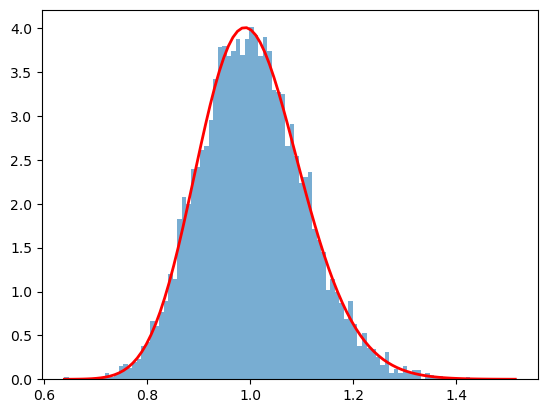

In [101]:
# Визуализация распределения
count, bins, ignored = plt.hist(s, 100, density=True, align='mid', alpha=0.6)
x = np.linspace(min(bins), max(bins), 100)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, linewidth=2, color='r')
plt.show()


In [106]:
# Сортировка
s = sorted(s)

In [113]:
# Бакетируем
n = 100
backets = np.array_split(s, n)



In [114]:
#берем среднее по каждому бакету
mean_backets = np.mean(backets, axis=1)
mean_backets

array([0.76230317, 0.80245346, 0.81930878, 0.83303918, 0.84377865,
       0.85239981, 0.85982919, 0.86579656, 0.87080789, 0.87522953,
       0.88032595, 0.88508933, 0.88946318, 0.89365875, 0.89804073,
       0.9018948 , 0.90575705, 0.90957964, 0.91329125, 0.91718247,
       0.92051431, 0.92366298, 0.92715017, 0.93058176, 0.93331919,
       0.93615305, 0.93892718, 0.94151922, 0.94442981, 0.94698938,
       0.94936   , 0.95202358, 0.95480282, 0.95762276, 0.96000985,
       0.96288292, 0.96528131, 0.96793963, 0.97093149, 0.97366136,
       0.97593632, 0.97859267, 0.98138547, 0.9841563 , 0.9867644 ,
       0.98962503, 0.9924345 , 0.9950103 , 0.9974994 , 0.99990567,
       1.00238059, 1.00484773, 1.00734318, 1.00982847, 1.01225512,
       1.01480437, 1.01756472, 1.0203026 , 1.02317831, 1.02593002,
       1.02839635, 1.03077487, 1.03344506, 1.0361595 , 1.03877256,
       1.0413202 , 1.04400876, 1.04690885, 1.05040128, 1.05341041,
       1.05649788, 1.05963793, 1.06296343, 1.06593447, 1.06885

In [115]:
stats.ttest_ind(mean_backets, s)

Ttest_indResult(statistic=0.0, pvalue=1.0)

#### p-value на T-test'e показывает, что различий нет

### На метрике cart_added_cnt 

In [151]:
# Сортировка
# Убираю 21 ноль, чтобы нормально отработала функция np.mean()
data = sorted(shop_metrics_new['cart_added_cnt'])[21:]

In [152]:
# Бакетируем
n = 100
backets = np.array_split(data, n)

In [154]:
#берем среднее по каждому бакету
mean_backets = np.mean(backets, axis=1)
mean_backets

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [155]:
stats.ttest_ind(mean_backets, data)

Ttest_indResult(statistic=4.3733280608280013e-16, pvalue=0.9999999999999997)

#### p-value на T-test'e показывает, что различий нет

## Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:


### на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+) подсчитать результаты для случая без постстратификации и с постстратификацией

In [271]:
shop_users_info = pd.read_csv('shop_df_users.csv').drop(columns='Unnamed: 0')
shop_users_info.head(3)

,user_id,user_age,user_sex
0,1515915625519388267,41,f
1,1515915625519380411,84,m
2,1515915625513238515,41,m


In [272]:
shop_w_features = pd.merge(shop_metrics_old, shop_users_info, on=['user_id'], how='left')
shop_w_features.head(3)

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,user_age,user_sex
0,1515915625353226922,B,1,1,76.48,0.0,0.0,0,0,55,f
1,1515915625353230067,A,1,1,28.98,0.0,0.0,0,0,58,m
2,1515915625353230683,A,1,10,592.21,0.0,0.0,0,0,23,f


In [273]:
shop_w_features['age_group'] = shop_w_features['user_age'] \
                                .mask((shop_w_features['user_age']>=18) & (shop_w_features['user_age'] <=24), '18-24') \
                                .mask((shop_w_features['user_age']>=25) & (shop_w_features['user_age'] <=45), '25-45') \
                                .mask((shop_w_features['user_age']>=46) & (shop_w_features['user_age'] <=60), '46-60') \
                                .mask((shop_w_features['user_age']>=61) & (shop_w_features['user_age'] <=75), '61-75') \
                                .mask(shop_w_features['user_age']>=76, '76+')

In [274]:
shop_w_features.groupby('group')['age_group'].value_counts(normalize=True)

group  age_group
A      25-45        0.314612
       46-60        0.224540
       61-75        0.221013
       76+          0.134624
       18-24        0.105210
B      25-45        0.314106
       61-75        0.223533
       46-60        0.223037
       76+          0.134842
       18-24        0.104482
Name: age_group, dtype: float64

In [275]:
stats.ttest_ind(shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'], 
                shop_w_features[shop_w_features.group == 'B']['cart_added_cnt'])

Ttest_indResult(statistic=-0.7331870372707812, pvalue=0.4634447828246868)

In [276]:
(shop_w_features[shop_w_features.group == 'B']['cart_added_cnt'].mean() - shop_w_features[shop_w_features.group == 'A']['purchased_cnt'].mean()) \
        /shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'].mean() * 100

49.497907920679424

In [277]:
print(shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'].std(), 
      shop_w_features[shop_w_features.group == 'B']['cart_added_cnt'].std())

0.5766891197798589 0.5987645651968048


In [278]:
N = shop_w_features['user_id'].nunique()
    
strats_weights = {}
    
for i in range(0, shop_w_features['age_group'].nunique()):
    key = shop_w_features['age_group'].value_counts().index[i]
    strats_weights[key] = shop_w_features['age_group'].value_counts()[i] / N
        

In [279]:
mean_a = shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '25-45')]['cart_added_cnt'].mean() * strats_weights['25-45']\
        + shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '46-60')]['cart_added_cnt'].mean() * strats_weights['46-60']\
        + shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '61-75')]['cart_added_cnt'].mean() * strats_weights['61-75']\
        + shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '76+')]['cart_added_cnt'].mean() * strats_weights['76+']\
        + shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '18-24')]['cart_added_cnt'].mean() * strats_weights['18-24']


In [280]:
mean_b = shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '25-45')]['cart_added_cnt'].mean() * strats_weights['25-45']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '46-60')]['cart_added_cnt'].mean() * strats_weights['46-60']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '61-75')]['cart_added_cnt'].mean() * strats_weights['61-75']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '76+')]['cart_added_cnt'].mean() * strats_weights['76+']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '18-24')]['cart_added_cnt'].mean() * strats_weights['18-24']


In [281]:
std_a = (shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '25-45')]['cart_added_cnt'].std()**2 * strats_weights['25-45']\
        + shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '46-60')]['cart_added_cnt'].std()**2 * strats_weights['46-60']\
        + shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '61-75')]['cart_added_cnt'].std()**2 * strats_weights['61-75']\
        + shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '76+')]['cart_added_cnt'].std()**2 * strats_weights['76+']\
        + shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '18-24')]['cart_added_cnt'].std()**2 * strats_weights['18-24'])/N


In [282]:
std_b = (shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '25-45')]['cart_added_cnt'].std()**2 * strats_weights['25-45']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '46-60')]['cart_added_cnt'].std()**2 * strats_weights['46-60']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '61-75')]['cart_added_cnt'].std()**2 * strats_weights['61-75']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '76+')]['cart_added_cnt'].std()**2 * strats_weights['76+']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '18-24')]['cart_added_cnt'].std()**2 * strats_weights['18-24'])/N


In [283]:
n_a = len(shop_w_features[shop_w_features.group == 'A'])
n_b = len(shop_w_features[shop_w_features.group == 'B'])

In [284]:
print(f'effect: {(mean_b - mean_a)/mean_a*100}, std_a: {std_a}, std_b: {std_b}')

stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b, std_b, n_b)

effect: 1.1245765283202334, std_a: 8.178193709120878e-07, std_b: 8.815974088285695e-07


Ttest_indResult(statistic=-507011.9533539134, pvalue=0.0)

In [290]:
stats.ttest_ind(shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'],
                shop_w_features[shop_w_features.group == 'B']['cart_added_cnt'])

Ttest_indResult(statistic=-90.84924168518585, pvalue=0.0)

P-value = 0 => выборки разные, отклоняем нулевую гипотезу

### Проверить мощность и корректность t-критерия для постстратифицированного случая

In [286]:
def poststrat(new_df):
    strats_weights = {}
    shop_w_features['age_group'] = new_df['user_age'] \
                                .mask((new_df['user_age']>=18) & (new_df['user_age'] <=24), '18-24') \
                                .mask((new_df['user_age']>=25) & (new_df['user_age'] <=45), '25-45') \
                                .mask((new_df['user_age']>=46) & (new_df['user_age'] <=60), '46-60') \
                                .mask((new_df['user_age']>=61) & (new_df['user_age'] <=75), '61-75') \
                                .mask(new_df['user_age']>=76, '76+')

    for i in range(0, shop_w_features['age_group'].nunique()):
        key = shop_w_features['age_group'].value_counts().index[i]
        strats_weights[key] = shop_w_features['age_group'].value_counts()[i] / N

    mean_a = shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '25-45')]['cart_added_cnt'].mean() * strats_weights['25-45']\
        + shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '46-60')]['cart_added_cnt'].mean() * strats_weights['46-60']\
        + shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '61-75')]['cart_added_cnt'].mean() * strats_weights['61-75']\
        + shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '76+')]['cart_added_cnt'].mean() * strats_weights['76+']\
        + shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '18-24')]['cart_added_cnt'].mean() * strats_weights['18-24']
    mean_b = shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '25-45')]['cart_added_cnt'].mean() * strats_weights['25-45']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '46-60')]['cart_added_cnt'].mean() * strats_weights['46-60']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '61-75')]['cart_added_cnt'].mean() * strats_weights['61-75']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '76+')]['cart_added_cnt'].mean() * strats_weights['76+']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '18-24')]['cart_added_cnt'].mean() * strats_weights['18-24']
    
    mean_b_ef = (shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '25-45')]['cart_added_cnt'].mean() * strats_weights['25-45']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '46-60')]['cart_added_cnt'].mean() * strats_weights['46-60']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '61-75')]['cart_added_cnt'].mean() * strats_weights['61-75']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '76+')]['cart_added_cnt'].mean() * strats_weights['76+']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '18-24')]['cart_added_cnt'].mean() * strats_weights['18-24'])


    std_a = (shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '25-45')]['cart_added_cnt'].std()**2 * strats_weights['25-45']\
        + shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '46-60')]['cart_added_cnt'].std()**2 * strats_weights['46-60']\
        + shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '61-75')]['cart_added_cnt'].std()**2 * strats_weights['61-75']\
        + shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '76+')]['cart_added_cnt'].std()**2 * strats_weights['76+']\
        + shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '18-24')]['cart_added_cnt'].std()**2 * strats_weights['18-24'])/N

    std_b = (shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '25-45')]['cart_added_cnt'].std()**2 * strats_weights['25-45']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '46-60')]['cart_added_cnt'].std()**2 * strats_weights['46-60']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '61-75')]['cart_added_cnt'].std()**2 * strats_weights['61-75']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '76+')]['cart_added_cnt'].std()**2 * strats_weights['76+']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '18-24')]['cart_added_cnt'].std()**2 * strats_weights['18-24'])/N
    
    n_a = len(shop_w_features[shop_w_features.group == 'A'])
    n_b = len(shop_w_features[shop_w_features.group == 'B'])
    
    shop_w_features.loc[shop_w_features.group == 'B','cart_added_cnt'] *= 1.05
    
    mean_b_ef = (shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '25-45')]['cart_added_cnt'].mean() * strats_weights['25-45']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '46-60')]['cart_added_cnt'].mean() * strats_weights['46-60']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '61-75')]['cart_added_cnt'].mean() * strats_weights['61-75']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '76+')]['cart_added_cnt'].mean() * strats_weights['76+']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '18-24')]['cart_added_cnt'].mean() * strats_weights['18-24'])

    std_b_ef = (shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '25-45')]['cart_added_cnt'].std()**2 * strats_weights['25-45']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '46-60')]['cart_added_cnt'].std()**2 * strats_weights['46-60']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '61-75')]['cart_added_cnt'].std()**2 * strats_weights['61-75']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '76+')]['cart_added_cnt'].std()**2 * strats_weights['76+']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '18-24')]['cart_added_cnt'].std()**2 * strats_weights['18-24'])/N
    
    return mean_a, std_a, n_a, mean_b, std_b, n_b, mean_b_ef, std_b_ef

In [292]:
correctness = []
power = []
shop = shop_metrics_old.drop(columns=['group'])

for i in tqdm(range(1000)):
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    new_df = pd.merge(new_df, shop_users_info, how="left", on=['user_id']).drop_duplicates()
    
    mean_a, std_a, n_a, mean_b, std_b, n_b, mean_b_ef, std_b_ef = poststrat(shop_w_features)
    
    p_cor = stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b, std_b, n_b)[1]
    p_pow = stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b_ef, std_b_ef, n_b)[1]
    
    correctness.append(p_cor)
    power.append(p_pow)

100%|███████████████████████████████████████| 1000/1000 [52:17<00:00,  3.14s/it]


<Axes: ylabel='Count'>

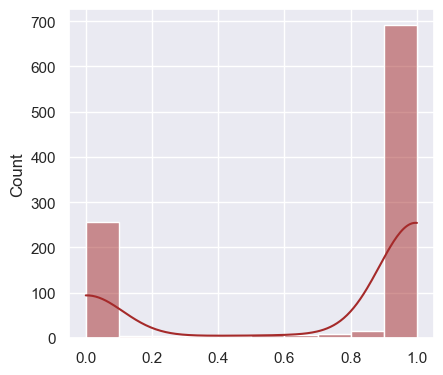

In [294]:
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

In [270]:
power = np.array(power)

correctness = np.array(correctness)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

 power: 100.0% , correctness: 0.0%


#### Вывод: Выборки разные, это показывает граффик, также легко просвечивается разница, если ее добавить. Правда и график p-value не равномерный 